In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./birdclef-2025-solution-eda-deep-learning-lb0-8.ipynb
./birdclef-2025.zip
./first.ipynb
./train.ipynb
./X.npy
./y_encoded.npy
./y_labels.npy
./birdclef-2025\recording_location.txt
./birdclef-2025\sample_submission.csv
./birdclef-2025\taxonomy.csv
./birdclef-2025\train.csv
./birdclef-2025\test_soundscapes\readme.txt
./birdclef-2025\train_audio\1139490\CSA36385.ogg
./birdclef-2025\train_audio\1139490\CSA36389.ogg
./birdclef-2025\train_audio\1192948\CSA36358.ogg
./birdclef-2025\train_audio\1192948\CSA36366.ogg
./birdclef-2025\train_audio\1192948\CSA36373.ogg
./birdclef-2025\train_audio\1192948\CSA36388.ogg
./birdclef-2025\train_audio\1194042\CSA18783.ogg
./birdclef-2025\train_audio\1194042\CSA18794.ogg
./birdclef-2025\train_audio\1194042\CSA18802.ogg
./birdclef-2025\train_audio\126247\iNat1109254.ogg
./birdclef-2025\train_audio\126247\iNat146584.ogg
./birdclef-2025\train_audio\126247\iNat320679.ogg
./birdclef-2025\train_audio\126247\iNat888527.ogg
./birdclef-2025\train_audio\126247\iNat8

https://www.kaggle.com/code/docxian/birdclef-2025-eda-geography

https://www.kaggle.com/code/xiaoazuzong/lb-0-778-efficientnet-b0-pytorch-inference/notebook


In [3]:
import os
import gc
import warnings
import logging
import time
import math
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
# import timm
from tqdm.auto import tqdm


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import librosa
import librosa.display
from IPython.display import Audio


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

c:\Users\pc\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CFG:
 
    test_soundscapes = './birdclef-2025/test_soundscapes'
    submission_csv = './birdclef-2025/sample_submission.csv'
    taxonomy_csv = './birdclef-2025/taxonomy.csv'
    model_path = './birdclef-2025-efficientnet-b0'  
    
    # Audio parameters
    FS = 32000  
    WINDOW_SIZE = 5  
    
    # Mel spectrogram parameters
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    TARGET_SHAPE = (256, 256)
    
    model_name = 'efficientnet_b0'
    in_channels = 1
    device = 'cpu'  
    
    # Inference parameters
    batch_size = 16
    use_tta = False  
    tta_count = 3   
    threshold = 0.5
    
    use_specific_folds = False  # If False, use all found models
    folds = [0, 1]  # Used only if use_specific_folds is True
    
    debug = False
    debug_count = 3

cfg = CFG()

In [4]:


# read train data file
df = pd.read_csv('./birdclef-2025/train.csv')

# read taxonomy file
df_taxo = pd.read_csv('./birdclef-2025/taxonomy.csv')

df = pd.merge(left=df, right=df_taxo[['primary_label', 'inat_taxon_id', 'class_name']], how='left', on='primary_label')


print(df.head())
print(df.info())
print(df.collection.value_counts())

  primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniel

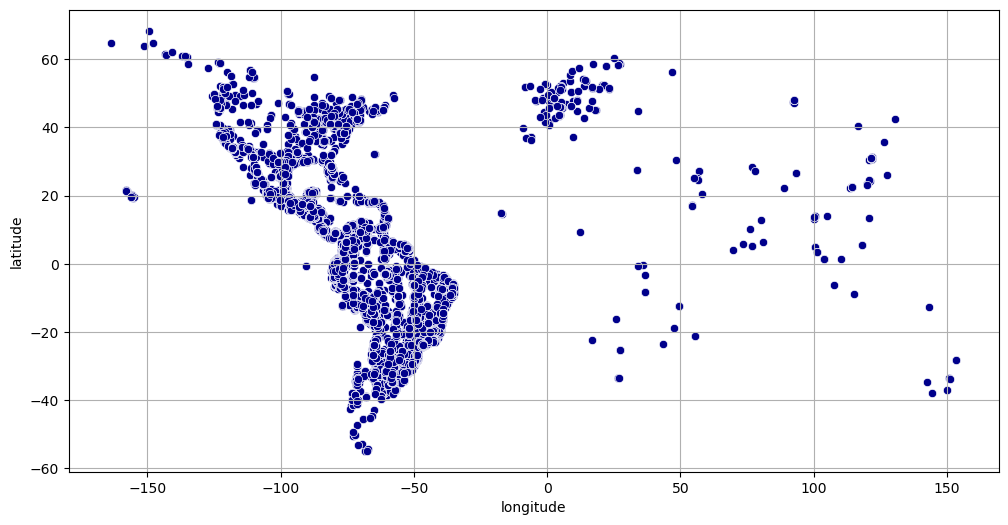

In [5]:
# first simple plot of locations
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='longitude', y='latitude', 
                color='darkblue')
plt.grid()
plt.show()

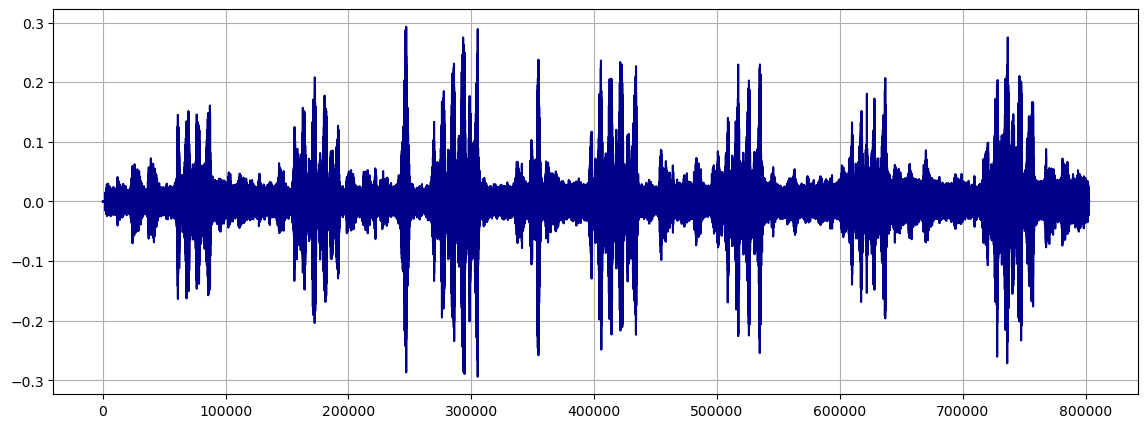

In [6]:

filename='XC112602.ogg'
y, sr = librosa.load('./birdclef-2025/train_audio/banana/' + filename)

# show wave data
plt.figure(figsize=(14,5))
plt.plot(y, color='darkblue')
plt.grid()
plt.show()



In [7]:
# play sound
Audio(y, rate=sr)

Audio Loaded! ✅ Duration: 24.77 seconds
Loaded: train_audio\1139490\CSA36385.ogg | Duration: 98.85 seconds
Loaded: train_audio\1139490\CSA36389.ogg | Duration: 96.54 seconds
Loaded: train_audio\1192948\CSA36358.ogg | Duration: 116.60 seconds


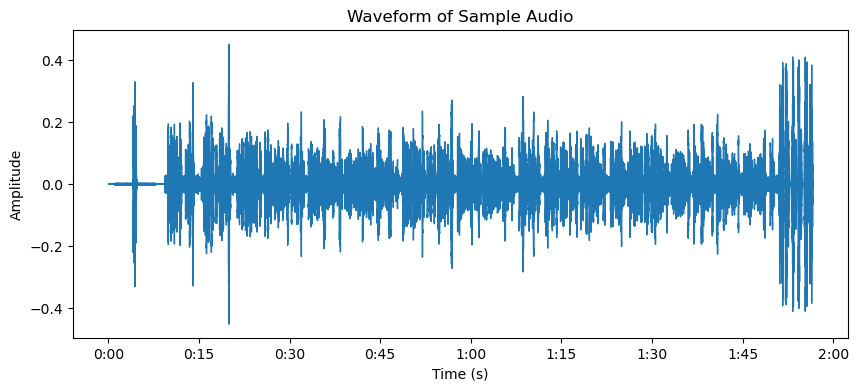

In [8]:
# audio_path = "./birdclef-2025/train_audio/XC12345.ogg"  # Example audio path
# y, sr = librosa.load(audio_path, sr=None)
# duration = librosa.get_duration(y=y, sr=sr)
# print(f"Duration: {duration:.2f} seconds")

# # Plot waveform
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(y, sr=sr)
# plt.title('Waveform of Sample Audio')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.show()


# def plot_spectrogram(audio_path):
#     y, sr = librosa.load(audio_path, sr=None)
#     S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#     S_dB = librosa.power_to_db(S, ref=np.max)

#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Mel Spectrogram')
#     plt.show()

# # Example usage
# plot_spectrogram(audio_path)


import librosa

# Correct file path from the list
audio_path = "./birdclef-2025/train_audio/greani1/XC132190.ogg"

# Load audio
y, sr = librosa.load(audio_path, sr=None)
print(f"Audio Loaded! ✅ Duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
import glob

# Get all OGG files from the subdirectories
all_audio_files = glob.glob("./birdclef-2025/train_audio/**/*.ogg", recursive=True)

# Load and analyze first 3 files
for audio_path in all_audio_files[:3]:
    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Loaded: {audio_path.split('/')[-1]} | Duration: {duration:.2f} seconds")

import librosa.display
import matplotlib.pyplot as plt

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Sample Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



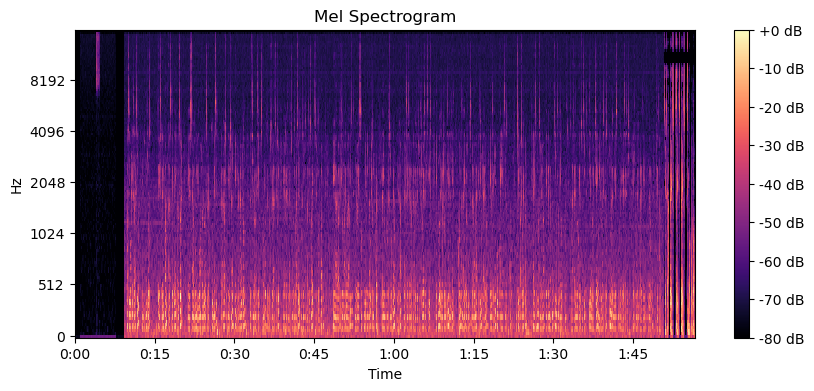

In [9]:
# Plot spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [10]:
def extract_features(audio_path, max_pad_len=128):
    y, sr = librosa.load(audio_path, sr=32000)  # Use 32 kHz as specified
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Pad or trim spectrogram
    if S_db.shape[1] < max_pad_len:
        pad_width = max_pad_len - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        S_db = S_db[:, :max_pad_len]

    return S_db

# Example feature extraction
audio_path = "./birdclef-2025/train_audio/trokin/iNat373653.ogg"
features = extract_features(audio_path)
print(f"Extracted Features Shape: {features.shape}")


Extracted Features Shape: (128, 128)


In [7]:
train_df = pd.read_csv('./birdclef-2025/train.csv')
taxonomy_df = pd.read_csv('./birdclef-2025/taxonomy.csv')
train_df = pd.merge(train_df, taxonomy_df[['primary_label', 'class_name']], how='left', on='primary_label')

train_df

primary_label secondary_labels  type               filename collection  \
0           1139490             ['']  ['']   1139490/CSA36385.ogg        CSA   
1           1139490             ['']  ['']   1139490/CSA36389.ogg        CSA   
2           1192948             ['']  ['']   1192948/CSA36358.ogg        CSA   
3           1192948             ['']  ['']   1192948/CSA36366.ogg        CSA   
4           1192948             ['']  ['']   1192948/CSA36373.ogg        CSA   
...             ...              ...   ...                    ...        ...   
28559        ywcpar             ['']  ['']   ywcpar/iNat77392.ogg       iNat   
28560        ywcpar             ['']  ['']   ywcpar/iNat78624.ogg       iNat   
28561        ywcpar             ['']  ['']  ywcpar/iNat789234.ogg       iNat   
28562        ywcpar             ['']  ['']  ywcpar/iNat819873.ogg       iNat   
28563        ywcpar             ['']  ['']  ywcpar/iNat922688.ogg       iNat   

       rating                                                url  latitude  \
0         0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1         0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2         0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3         0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4         0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
...       ...                                                ...       ...   
28559     0.0    https://static.inaturalist.org/sounds/77392.m4a    7.6921   
28560     0.0    https://static.inaturalist.org/sounds/78624.wav    8.9918   
28561     0.0   https://static.inaturalist.org/sounds/789234.wav    9.2316   
28562     0.0   https://static.inaturalist.org/sounds/819873.mp3   10.5838   
28563     0.0   https://static.inaturalist.org/sounds/922688.wav    9.1156   

       longitude        scientific_name            common_name  \
0       -73.7128   Ragoniella pulchella   Ragoniella pulchella   
1       -73.7128   Ragoniella pulchella   Ragoniella pulchella   
2       -73.7313  Oxyprora surinamensis  Oxyprora surinamensis   
3       -73.8582  Oxyprora surinamensis  Oxyprora surinamensis   
4       -73.7313  Oxyprora surinamensis  Oxyprora surinamensis   
...          ...                    ...                    ...   
28559   -80.3379   Amazona ochrocephala  Yellow-crowned Parrot   
28560   -79.4877   Amazona ochrocephala  Yellow-crowned Parrot   
28561   -70.2041   Amazona ochrocephala  Yellow-crowned Parrot   
28562   -66.8545   Amazona ochrocephala  Yellow-crowned Parrot   
28563   -79.4907   Amazona ochrocephala  Yellow-crowned Parrot   

                  author          license class_name  
0      Fabio A. Sarria-S  cc-by-nc-sa 4.0    Insecta  
1      Fabio A. Sarria-S  cc-by-nc-sa 4.0    Insecta  
2      Fabio A. Sarria-S  cc-by-nc-sa 4.0    Insecta  
3      Fabio A. Sarria-S  cc-by-nc-sa 4.0    Insecta  
4      Fabio A. Sarria-S  cc-by-nc-sa 4.0    Insecta  
...                  ...              ...        ...  
28559    Yennifer Alfaro     cc-by-nc 4.0       Aves  
28560      Evan Centanni  cc-by-nc-sa 4.0       Aves  
28561             Henrry        cc-by 4.0       Aves  
28562      Alejandro Luy     cc-by-nc 4.0       Aves  
28563        Kalvin Chan         cc-0 4.0       Aves  

[28564 rows x 14 columns]

In [12]:
len(train_df.primary_label.unique())

206

In [13]:
train_df['primary_label'].value_counts().head(10)

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import librosa
# import cv2
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
# from tqdm import tqdm

# # Pad or truncate to fixed shape
# def pad_or_truncate(S, max_len=128):
#     """Pad or truncate the spectrogram to a fixed size of 128x128."""
#     if S.shape[1] < max_len:
#         # Pad with zeros if shorter
#         pad_width = max_len - S.shape[1]
#         S = np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
#     else:
#         # Truncate if longer
#         S = S[:, :max_len]

#     return S

# # Extract features with padding/truncation
# def extract_features(audio_path):
#     try:
#         y, sr = librosa.load(audio_path, sr=None)
#         S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#         S_dB = librosa.power_to_db(S, ref=np.max)

#         # Pad or truncate the spectrogram to 128x128
#         S_fixed = pad_or_truncate(S_dB, max_len=128)
        
#         return S_fixed
#     except Exception as e:
#         print(f"❌ Error processing {audio_path}: {e}")
#         return None

# # Load a small portion of the dataset
# sample_df = train_df # .sample(100, random_state=42)  # Use 100 samples to keep it small
# X, y = [], []

# # Process files and extract features
# for i, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0], desc="Processing audio files"):
#     audio_file = f"./birdclef-2025/train_audio/{row['filename']}"
#     if os.path.exists(audio_file):
#         feature = extract_features(audio_file)
        
#         # Check for valid feature shape
#         if feature is not None and feature.shape == (128, 128):
#             X.append(np.stack([feature] * 3, axis=-1))  # Convert 1-channel to 3-channel
#             y.append(row['primary_label'])
#         else:
#             print(f"⚠️ Skipping {row['filename']} due to invalid feature shape.")

# # Convert to numpy arrays and reshape for CNN input
# if len(X) == 0 or len(y) == 0:
#     raise ValueError("❌ No valid audio files were processed. Check file paths and feature extraction!")

# X = np.array(X)
# # X = X.reshape(X.shape[0], 128, 128, 3)  # Reshape for CNN input
# y_encoded, y_labels = pd.factorize(y)  # Encode text labels as integers
# y = to_categorical(y_encoded)

# # Split data into training and validation
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"✅ Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")


Processing audio files:   0%|          | 0/28564 [00:00<?, ?it/s]

Processing audio files: 100%|██████████| 28564/28564 [1:02:26<00:00,  7.62it/s]


✅ Training data shape: (22851, 128, 128, 3), Validation data shape: (5713, 128, 128, 3)


In [ ]:
# np.save('X.npy', X)
# np.save('y_encoded.npy', y_encoded)
# np.save('y_labels.npy', y_labels)

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.load('resized_data.npy')
y_encoded = np.load('y_encoded.npy')
y_labels = np.load('y_labels.npy', allow_pickle=True)

In [9]:
import os
import numpy as np
import pandas as pd
import librosa
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = to_categorical(y_encoded)

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
len(X)

28564

In [60]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([4684455,   22851], dtype=int64))

In [10]:
print(f"✅ Files successfully processed: {len(X)}")
num_classes = len(np.unique(y_encoded))
print(f"✅ Unique classes: {num_classes}")


✅ Files successfully processed: 28564
✅ Unique classes: 206


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam


# Define the optimized CNN model
def build_cnn_model(input_shape=(128, 128, 1), num_classes=206):
    
   # Load EfficientNet Model
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    # base_model.summary()
    base_model.trainable = False  # Freeze base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(num_classes, activation="softmax")  # 397 bird species classes
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



    return model


# Build and compile the improved model
model = build_cnn_model(input_shape=(128, 128, 3), num_classes=len(y_labels))

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 206)               263886    
                                                                 
Total params: 4,313,457
Trainable params: 263,886
Non-trainable params: 4,049,571
_________________________________________________________________


In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [2]:
#  Enable Dynamic Memory Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'Error: {e}')


In [13]:
import tensorflow as tf

# 🏋️‍♂️ Training (No Aug, No Class Weights)
history = model.fit(
    X_train / 255.0, y_train,
    validation_data=(X_val / 255.0, y_val),
    epochs=10,
    batch_size=8,
    callbacks=[
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [70]:
y_train.dtype

dtype('float32')

In [ ]:
X_train[0][0]

array([[-58.141262 ],
       [-28.752348 ],
       [-19.192867 ],
       [-14.729216 ],
       [-15.365126 ],
       [-16.655045 ],
       [-17.1683   ],
       [-17.97802  ],
       [-16.347054 ],
       [-17.11657  ],
       [-25.719496 ],
       [-18.862991 ],
       [-17.619638 ],
       [-17.68742  ],
       [-16.554688 ],
       [-14.703278 ],
       [-19.536366 ],
       [-22.749336 ],
       [-22.971622 ],
       [-20.76442  ],
       [-14.834269 ],
       [-16.558405 ],
       [-19.605673 ],
       [-17.606327 ],
       [-17.748585 ],
       [-21.66756  ],
       [-19.403023 ],
       [-17.570477 ],
       [-16.97577  ],
       [-20.459766 ],
       [-14.7974415],
       [-19.364988 ],
       [-20.2813   ],
       [-15.539484 ],
       [-15.550739 ],
       [-14.545233 ],
       [-13.950979 ],
       [-18.072227 ],
       [-16.34813  ],
       [-12.624359 ],
       [-15.521502 ],
       [-22.938545 ],
       [-23.242477 ],
       [-21.060808 ],
       [-24.808046 ],
       [-2

In [23]:
len(y_labels)

128

In [31]:
np.unique(y_train, axis=0, return_counts=True)

(array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([ 1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  2,  2,  1,  2,
         2,  2,  1,  2,  4,  2,  1,  2,  2,  1,  2,  1,  3,  2,  3,  1,  1,
         3,  4,  3,  1,  3,  3,  6,  8,  4,  1,  1,  3,  1,  2,  2,  4,  1,
         2,  1,  1,  5,  3,  4,  5,  3,  1,  1,  1,  8,  1,  6,  2,  1, 10,
         2,  3,  1,  2,  2,  6,  3,  7,  6,  2,  4,  5,  4,  7,  3,  5,  8,
         5,  2,  4,  3,  4,  1,  3, 11, 13,  5,  5,  3,  6,  1,  2,  7,  2,
         4, 10,  5,  9,  1,  2,  5,  4,  7,  1, 15,  6,  5,  1,  1,  2,  4,
         6,  5], dtype=int64))

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# # 📚 Dummy Dataset (Replace with real data)
# X_train = np.random.rand(300, 64, 64, 3)
# y_train = np.random.randint(0, 5, 300)
# X_val = np.random.rand(50, 64, 64, 3)
# y_val = np.random.randint(0, 5, 50)

# 🧠 One-Hot Encoding
# y_train = tf.keras.utils.to_categorical(y_train, 5)
# y_val = tf.keras.utils.to_categorical(y_val, 5)

# 🎨 Model (Back to Basics)
model = Sequential()

# 🔥 Conv Layer 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 🔥 Conv Layer 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 🔥 Conv Layer 3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 🧠 Flatten and Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# ⚡️ Compile with a higher LR
# model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Correct loss for one-hot labels
    metrics=['accuracy']
)

# 🏋️‍♂️ Training (No Aug, No Class Weights)
history = model.fit(
    X_train / 255.0, y_train,
    validation_data=(X_val / 255.0, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# 📈 Evaluate
val_loss, val_acc = model.evaluate(X_val / 255.0, y_val)
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")

In [ ]:
# print(y_train[:5])  # If this looks like [0, 1, 2, 3, 4] — use sparse_categorical_crossentropy
# print(y_train_onehot[:5])  # If this looks like one-hot — use categorical_crossentropy


In [ ]:
# import numpy as np
# unique, counts = np.unique(y_train, return_counts=True)
# print(dict(zip(unique, counts)))
# print(X_val.shape, y_val.shape)
# print(np.argmax(y_val[:5], axis=1))  # Check first few labels
# preds = model.predict(X_val / 255.0)
# print(np.argmax(preds[:5], axis=1))  # Check predictions


In [2]:
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# # 📸 Load MobileNetV2 with pre-trained ImageNet weights, excluding the top layer
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# # 🛠️ Add custom classification head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
# predictions = Dense(5, activation='softmax')(x)

# # 🧠 Create final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # 🧊 Freeze base model layers initially
# for layer in base_model.layers:
#     layer.trainable = False

# # 🚀 Compile the model with a small learning rate for initial training
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # 📉 Callbacks for better training
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # 🏋️‍♂️ Train the model (initial training with frozen base layers)
# history = model.fit(
#     X_train / 255.0, y_train_onehot,
#     validation_data=(X_val / 255.0, y_val_onehot),
#     epochs=10,
#     batch_size=32,
#     callbacks=[reduce_lr, early_stop]
# )

# # 🔓 Unfreeze some of the top layers in base_model for fine-tuning
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# # 🆙 Recompile with a smaller learning rate for fine-tuning
# model.compile(
#     optimizer=Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # 🎯 Fine-tuning the model with more epochs
# fine_tune_history = model.fit(
#     X_train / 255.0, y_train_onehot,
#     validation_data=(X_val / 255.0, y_val_onehot),
#     epochs=10,
#     batch_size=32,
#     callbacks=[reduce_lr, early_stop]
# )


In [ ]:
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)

In [ ]:
class BirdCLEFModel(nn.Module):
    def __init__(self, cfg, num_classes):
        super().__init__()
        self.cfg = cfg
        
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=False,  
            in_chans=cfg.in_channels,
            drop_rate=0.0,    
            drop_path_rate=0.0
        )
        
        if 'efficientnet' in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'resnet' in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            backbone_out = self.backbone.get_classifier().in_features
            self.backbone.reset_classifier(0, '')
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = backbone_out
        self.classifier = nn.Linear(backbone_out, num_classes)
        
    def forward(self, x):
        features = self.backbone(x)
        
        if isinstance(features, dict):
            features = features['features']
            
        if len(features.shape) == 4:
            features = self.pooling(features)
            features = features.view(features.size(0), -1)
        
        logits = self.classifier(features)
        return logits

In [ ]:
def audio2melspec(audio_data, cfg):
    """Convert audio data to mel spectrogram"""
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=cfg.FS,
        n_fft=cfg.N_FFT,
        hop_length=cfg.HOP_LENGTH,
        n_mels=cfg.N_MELS,
        fmin=cfg.FMIN,
        fmax=cfg.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

def process_audio_segment(audio_data, cfg):
    """Process audio segment to get mel spectrogram"""
    if len(audio_data) < cfg.FS * cfg.WINDOW_SIZE:
        audio_data = np.pad(audio_data, 
                          (0, cfg.FS * cfg.WINDOW_SIZE - len(audio_data)), 
                          mode='constant')
    
    mel_spec = audio2melspec(audio_data, cfg)
    
    # Resize if needed
    if mel_spec.shape != cfg.TARGET_SHAPE:
        mel_spec = cv2.resize(mel_spec, cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        
    return mel_spec.astype(np.float32)

In [ ]:
def find_model_files(cfg):
    """
    Find all .pth model files in the specified model directory
    """
    model_files = []
    
    model_dir = Path(cfg.model_path)
    
    for path in model_dir.glob('**/*.pth'):
        model_files.append(str(path))
    
    return model_files

def load_models(cfg, num_classes):
    """
    Load all found model files and prepare them for ensemble
    """
    models = []
    
    model_files = find_model_files(cfg)
    
    if not model_files:
        print(f"Warning: No model files found under {cfg.model_path}!")
        return models
    
    print(f"Found a total of {len(model_files)} model files.")
    
    if cfg.use_specific_folds:
        filtered_files = []
        for fold in cfg.folds:
            fold_files = [f for f in model_files if f"fold{fold}" in f]
            filtered_files.extend(fold_files)
        model_files = filtered_files
        print(f"Using {len(model_files)} model files for the specified folds ({cfg.folds}).")
    
    for model_path in model_files:
        try:
            print(f"Loading model: {model_path}")
            checkpoint = torch.load(model_path, map_location=torch.device(cfg.device))
            
            model = BirdCLEFModel(cfg, num_classes)
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(cfg.device)
            model.eval()
            
            models.append(model)
        except Exception as e:
            print(f"Error loading model {model_path}: {e}")
    
    return models

def predict_on_spectrogram(audio_path, models, cfg, species_ids):
    """Process a single audio file and predict species presence for each 5-second segment"""
    predictions = []
    row_ids = []
    soundscape_id = Path(audio_path).stem
    
    try:
        print(f"Processing {soundscape_id}")
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)
        
        total_segments = int(len(audio_data) / (cfg.FS * cfg.WINDOW_SIZE))
        
        for segment_idx in range(total_segments):
            start_sample = segment_idx * cfg.FS * cfg.WINDOW_SIZE
            end_sample = start_sample + cfg.FS * cfg.WINDOW_SIZE
            segment_audio = audio_data[start_sample:end_sample]
            
            end_time_sec = (segment_idx + 1) * cfg.WINDOW_SIZE
            row_id = f"{soundscape_id}_{end_time_sec}"
            row_ids.append(row_id)

            if cfg.use_tta:
                all_preds = []
                
                for tta_idx in range(cfg.tta_count):
                    mel_spec = process_audio_segment(segment_audio, cfg)
                    mel_spec = apply_tta(mel_spec, tta_idx)

                    mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                    mel_spec = mel_spec.to(cfg.device)

                    if len(models) == 1:
                        with torch.no_grad():
                            outputs = models[0](mel_spec)
                            probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
                            all_preds.append(probs)
                    else:
                        segment_preds = []
                        for model in models:
                            with torch.no_grad():
                                outputs = model(mel_spec)
                                probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
                                segment_preds.append(probs)
                        
                        avg_preds = np.mean(segment_preds, axis=0)
                        all_preds.append(avg_preds)

                final_preds = np.mean(all_preds, axis=0)
            else:
                mel_spec = process_audio_segment(segment_audio, cfg)
                
                mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                mel_spec = mel_spec.to(cfg.device)
                
                if len(models) == 1:
                    with torch.no_grad():
                        outputs = models[0](mel_spec)
                        final_preds = torch.sigmoid(outputs).cpu().numpy().squeeze()
                else:
                    segment_preds = []
                    for model in models:
                        with torch.no_grad():
                            outputs = model(mel_spec)
                            probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
                            segment_preds.append(probs)

                    final_preds = np.mean(segment_preds, axis=0)
                    
            predictions.append(final_preds)
            
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
    
    return row_ids, predictions

In [ ]:
def apply_tta(spec, tta_idx):
    """Apply test-time augmentation"""
    if tta_idx == 0:
        # Original spectrogram
        return spec
    elif tta_idx == 1:
        # Time shift (horizontal flip)
        return np.flip(spec, axis=1)
    elif tta_idx == 2:
        # Frequency shift (vertical flip)
        return np.flip(spec, axis=0)
    else:
        return spec

def run_inference(cfg, models, species_ids):
    """Run inference on all test soundscapes"""
    test_files = list(Path(cfg.test_soundscapes).glob('*.ogg'))
    
    if cfg.debug:
        print(f"Debug mode enabled, using only {cfg.debug_count} files")
        test_files = test_files[:cfg.debug_count]
    
    print(f"Found {len(test_files)} test soundscapes")

    all_row_ids = []
    all_predictions = []

    for audio_path in tqdm(test_files):
        row_ids, predictions = predict_on_spectrogram(str(audio_path), models, cfg, species_ids)
        all_row_ids.extend(row_ids)
        all_predictions.extend(predictions)
    
    return all_row_ids, all_predictions

def create_submission(row_ids, predictions, species_ids, cfg):
    """Create submission dataframe"""
    print("Creating submission dataframe...")

    submission_dict = {'row_id': row_ids}
    
    for i, species in enumerate(species_ids):
        submission_dict[species] = [pred[i] for pred in predictions]

    submission_df = pd.DataFrame(submission_dict)

    submission_df.set_index('row_id', inplace=True)

    sample_sub = pd.read_csv(cfg.submission_csv, index_col='row_id')

    missing_cols = set(sample_sub.columns) - set(submission_df.columns)
    if missing_cols:
        print(f"Warning: Missing {len(missing_cols)} species columns in submission")
        for col in missing_cols:
            submission_df[col] = 0.0

    submission_df = submission_df[sample_sub.columns]

    submission_df = submission_df.reset_index()
    
    return submission_df

In [ ]:
def main():
    start_time = time.time()
    print("Starting BirdCLEF-2025 inference...")
    print(f"TTA enabled: {cfg.use_tta} (variations: {cfg.tta_count if cfg.use_tta else 0})")

    models = load_models(cfg, num_classes)
    
    if not models:
        print("No models found! Please check model paths.")
        return
    
    print(f"Model usage: {'Single model' if len(models) == 1 else f'Ensemble of {len(models)} models'}")

    row_ids, predictions = run_inference(cfg, models, species_ids)

    submission_df = create_submission(row_ids, predictions, species_ids, cfg)

    submission_path = 'submission.csv'
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission saved to {submission_path}")
    
    end_time = time.time()
    print(f"Inference completed in {(end_time - start_time)/60:.2f} minutes")

In [ ]:


if __name__ == "__main__":
    main()

